In [7]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import urllib.request
import zipfile
import io
import random as rnd
import seaborn as sns

# 2.重回帰
### 重回帰とは
前章では説明変数が１次の単回帰について取り扱った。しかし説明変数が１次、つまり直線$y=ax+b$へのフィッティングでは十分な回帰性能を得られない可能性がある。そこで本章では説明変数を２つ以上に増やし分析を行う。この方法を単回帰と区別して**重回帰**と呼ぶ。

### 重回帰モデル
重回帰で用いるモデルは一般に以下のような多項式である。
$$
\hat{y} = w_{0} + w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + \cdots + w_{d}x_{d} \qquad (1)
$$
また、$w_{0}, w_{1}, w_{2}, w_{3}, \cdots , w_{d}$はモデルの**重み**で、この値を求めいていくことになる。
ここで式をより扱いやすくするために以下のように各パラメータを列ベクトルで表現する。
$d$個の説明変数を並べたベクトル$\boldsymbol{x}$は
$$
\begin{gather}
    \boldsymbol{x} = \begin{pmatrix} 
        x_{1}\\ 
        \vdots \\ 
        x_{d} \\ 
        \notag 
        \end{pmatrix}
\end{gather}
$$
重みも同様にして  
$$
\begin{gather}
    \boldsymbol{w} = \begin{pmatrix}
        w_{1}\\
        \vdots \\
        w_{d} \\
        \notag
        \end{pmatrix}
\end{gather}
$$
また予測値$y_{i}$をN個並べた目的変数ベクトル$\boldsymbol{\hat{y}}$は
$$
\begin{gather}
    \boldsymbol{\boldsymbol{\hat{y}}} = 
        \begin{pmatrix}
        y_{1}\\
        \vdots \\
        y_{\tiny N} \\
        \notag
        \end{pmatrix}
\end{gather}
$$
また単回帰と同様に$N$個の事例からなるデータ$D$は
$$
\begin{align}
\mathcal{D} = \left\{(\boldsymbol{x}_1, y_1), (\boldsymbol{x}_2, y_2), \dots, (\boldsymbol{x}_N, y_N)\right\} = \left
\{(\boldsymbol{x}_i, y_i)\right\}_{i=1}^{N} \notag
\end{align}
$$
$N$個の説明変数を行列にまとめると、
$$
\begin{align}
\boldsymbol{X} = \begin{pmatrix}
\boldsymbol{x}_1^\top \\
\boldsymbol{x}_2^\top \\
\vdots \\
\boldsymbol{x}_N^\top \\
\end{pmatrix}
= \begin{pmatrix}
X_{1,1} & X_{1,2} & \dots & X_{1,d} \\
X_{2,1} & X_{2,2} & \dots & X_{2,d} \\
\vdots & \vdots & \ddots & \vdots \\
X_{N,1} & X_{N,2} & \dots & X_{N,d} \notag
\end{pmatrix}
\end{align}
$$
この行列は特に**計画行列**という。
よって目的変数$\boldsymbol{\hat{y}}$は以下のように表される。
$$
\boldsymbol{\hat{y}} = \boldsymbol{X}\boldsymbol{w}
$$

### パラメータ推定
単回帰と同様に残差を使用し最小2乗法によってパラメータを推定していく。
目的変数の実測値$y_{i}$とモデルの予測値$\hat{y}_{i}$の差$\epsilon_{i}$は
$$
\epsilon_{i} = y_{i} - \hat{y}_{i} = y_{i} - \boldsymbol{X}\boldsymbol{w}
$$
よって学習データにおける平均二乗誤差$\hat{L}$は
$$
\begin{align}
\hat{L} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2 = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 = 
  \frac{1}{N} \sum_{i=1}^{N} (y_i - \boldsymbol{x}_i^\top\boldsymbol{w})^2 \notag
\end{align} 
$$
またすべての事例の残差をベクトル$\boldsymbol{\epsilon}$は
$$
\begin{gather}
    \boldsymbol{\epsilon} = 
        \begin{pmatrix}
        \epsilon_{1}\\
        \vdots \\
        \epsilon_{d} \\
        \notag
        \end{pmatrix}
\end{gather}
$$
となるので、重回帰の目的関数$\hat{L}_{D}(\boldsymbol{w})$は
$$
\begin{align}
\hat{L}_{\mathcal{D}}(\boldsymbol{w}) = \lVert \boldsymbol{\epsilon} \rVert^2 = \lVert \boldsymbol{y} - \boldsymbol{X}\boldsymbol{w} \rVert^2  \notag
\end{align}
$$
これを最小化したいので偏微分を求めその値を0と置き、パラメータ$\boldsymbol{w}$を求める式を導出する。
目的関数より、
$$
\begin{align}
\hat{L}_{\mathcal{D}}(\boldsymbol{w}) &= \lVert \boldsymbol{y} - \boldsymbol{X}\boldsymbol{w} \rVert^2 \notag \\ 
&= (\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w})^\top(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w}) \notag \\ 
&= \boldsymbol{y}^\top \boldsymbol{y} - \boldsymbol{y}^\top \boldsymbol{X}\boldsymbol{w} - \boldsymbol{w}^\top \boldsymbol{X}^\top \boldsymbol{y} + \boldsymbol{w}^\top \boldsymbol{X}^\top \boldsymbol{X}\boldsymbol{w} \notag \\  
&= \boldsymbol{y}^\top \boldsymbol{y} - 2(\boldsymbol{X}^\top\boldsymbol{y})^\top \boldsymbol{w} + \boldsymbol{w}^\top \boldsymbol{X}^\top \boldsymbol{X}\boldsymbol{w}\notag
\end{align} 
$$
$\boldsymbol{w}$について偏微分すると、
$$
\begin{align}
\nabla \hat{L}_{\mathcal{D}}(\boldsymbol{w}) 
  &= 0 - 2\boldsymbol{X}^\top \boldsymbol{y} +  2\boldsymbol{X}^\top \boldsymbol{X}\boldsymbol{w} \notag
  = 2\boldsymbol{X}^\top (\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y})
\end{align} 
$$
これを$\boldsymbol{0}$と置くと、
$$
\begin{align}
\nabla \hat{L}_{\mathcal{D}}(\boldsymbol{w}) &= \boldsymbol{0} \notag \\
2\boldsymbol{X}^\top (\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y}) &= \boldsymbol{0} \notag \\
\boldsymbol{X}^\top \boldsymbol{X}\boldsymbol{w} &= \boldsymbol{X}^\top \boldsymbol{y} \notag \\
\boldsymbol{w} &= (\boldsymbol{X}^\top \boldsymbol{X})^{-1}\boldsymbol{X}^\top \boldsymbol{y} \qquad (*)\notag
\end{align}
$$

### 決定係数
単回帰の際と同様に以下のような式になる。
$$
R^2 = 1 - \frac{\sum\limits_{i=1}^{N}\epsilon_{i}^2}{\sum\limits_{i=1}^{N}Y_{i}^2} = 1 - \dfrac{\dfrac{1}{N} \sum\limits_{i=1}^{N}\epsilon_{i}^2}{\dfrac{1}{N}\sum\limits_{i=1}^{N}(y_{i} - \bar{y})^2}
$$

### 多項式モデル
確認問題に入る前に前節で行った確認問題を重回帰へ拡張することを考える。前節の単回帰では１次関数へフィッティングすることをしたがデータによっては２次関数や３次関数へフィッティングするほうが好ましい結果が得あられる場合がある。
前節と同様に以下のデータについて考える。
$$ 
D = \{(x_{i}, y_{i})\}_{i=1}^{N}= \{(6, 17), (7, 11), (5, 1), (9, 12), (10, 2)\} 
$$
このデータを2次関数、3次関数それぞれにフィッティングすることを考える。したがってモデルは以下のようになる。
- 2次関数  
$\qquad \hat{y} = w_{1} + w_{2}x + w_{3}x^2$ 
- 3次関数  
$\qquad \hat{y} = w_{1} + w_{2}x + w_{3}x^2 + w_{4}x^3$  
これらのモデルのパラメータを求めそれをプロットし、それぞれの決定係数を以下に示す。

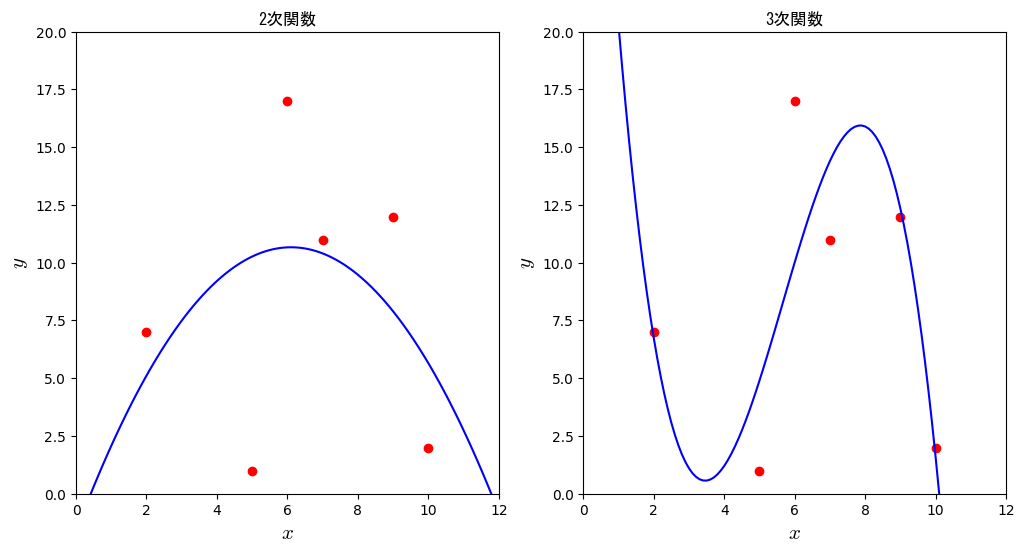

2次関数モデルの決定係数: 0.16314357709230387
3次関数モデルの決定係数: 0.6032835098348427


In [34]:
D = np.array([[6, 17],[7, 11], [5, 1], [9, 12], [10, 2], [2, 7]])
x = np.arange(0, 12, 0.1)
#２次関数モデル
# X1 = np.array([[1, D[i, 0], D[i, 0] ** 2] for i in range(len(D[:, 0]))])
X1 = np.array([[D[j, 0] ** i for i in range(3)] for j in range(len(D[:, 0]))])
y = np.array (D[:, 1])


W1 = np.linalg.inv(X1.T @ X1) @ X1.T @ y

#３次関数モデル
X2 = np.array([[1, D[i, 0], D[i, 0] ** 2, D[i, 0] ** 3] for i in range(len(D[:, 0]))])

W2 = np.linalg.inv(X2.T @ X2) @ X2.T @ y


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(D[:, 0], D[:, 1], c='red')
ax[0].plot(x, W1[0] + W1[1] * x + W1[2] * x ** 2, c='blue')
ax[0].set_xlim(0, 12)
ax[0].set_ylim(0, 20)
ax[0].set_xlabel(r'$x$', fontsize=15)
ax[0].set_ylabel(r'$y$', fontsize=15)
ax[0].set_title('2次関数', fontname='MS Gothic')

ax[1].scatter(D[:, 0], D[:, 1], c='red')
ax[1].plot(x, W2[0] + W2[1] * x + W2[2] * x ** 2 + W2[3] * x ** 3, c='blue')
ax[1].set_xlim(0, 12)
ax[1].set_ylim(0, 20)
ax[1].set_xlabel(r'$x$', fontsize=15)
ax[1].set_ylabel(r'$y$', fontsize=15)
ax[1].set_title('3次関数', fontname='MS Gothic')

plt.show()





epsilon1 = np.empty(len(D[:, 0]))
epsilon2 = np.empty(len(D[:, 0]))
for i in range(len(D[:, 0])):
    epsilon1[i] = y[i] - (W1[0] + W1[1] * D[i, 0] + W1[2] * D[i, 0] ** 2)
    epsilon2[i] = y[i] - (W2[0] + W2[1] * D[i, 0] + W2[2] * D[i, 0] ** 2 + W2[3] * D[i, 0] ** 3)

R2_1 = 1 - np.var(epsilon1) / np.var(y)
R2_2 = 1 - np.var(epsilon2) / np.var(y)
print(f'2次関数モデルの決定係数: {R2_1}')
print(f'3次関数モデルの決定係数: {R2_2}')



以上の結果から分かるように1、2次関数でフィッティングするよりも3次関数でフィッティングしたほうが良い結果が得られている。しかし本来線形回帰モデルはこの節の冒頭で示した式(1)のような形をしており、今使用した2次関数もでるや、3次関数モデルのような形をしていないように見えるが、これらのモデルも以下のような読み替えを行えば重回帰モデルの一種である。  
- 2次関数モデル  
$
\left \{
    \begin{array}{l}
        x_1 \\
        x_2
    \end{array}
\right .
\rightarrow
\left \{
    \begin{array}{l}
        x \\
        x^2
    \end{array}
\right .
$

- 3次関数モデル  
$
\left \{
    \begin{array}{l}
        x_1 \\
        x_2 \\
        x_3
    \end{array}
\right .
\rightarrow
\left \{
    \begin{array}{l}
        x \\
        x^2 \\
        x^3
    \end{array}
\right .
$

### 過学習
3次関数へのフィッティングでもわかるように次数を上げると精度が上がっている。そこで精度を上げるためさらに次数を上げてみることにする。ここではseabornライブラリからデータセットを読み込み、8次関数へフィッティングを行うことで、車の馬力から燃費を予測する回帰問題を考える。
まず取得したデータを以下にプロットする。

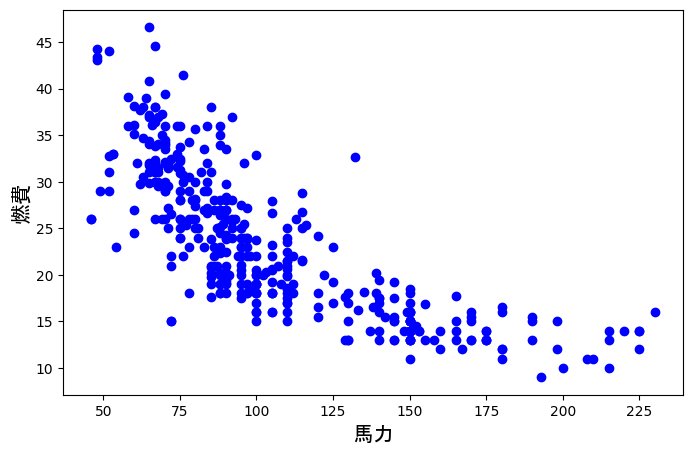

In [8]:
import seaborn as sns
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
D = df[['horsepower', 'mpg']].values

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(D[:, 0], D[:, 1], 'o', c='blue')

ax.set_xlabel('馬力', fontsize=15, fontname='MS Gothic')
ax.set_ylabel('燃費', fontsize=15, fontname='MS Gothic')

plt.show()

取得したデータから全体の5%のデータをランダムに訓練データを抽出し8次関数へのフィッティングを行う。求めた回帰直線を以下に示す。

(20,)


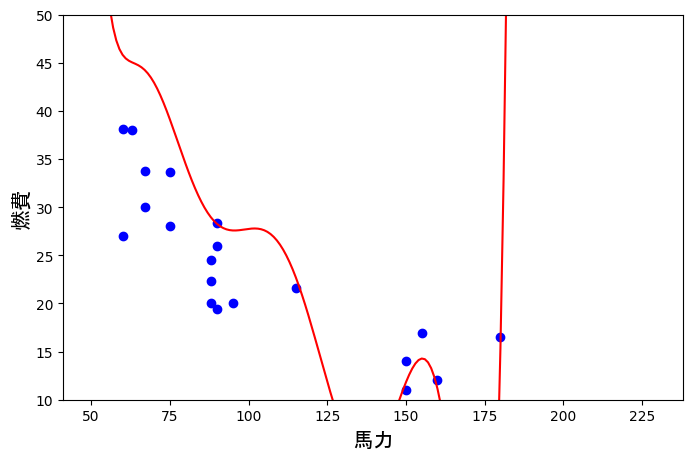

In [10]:
data = df[['horsepower', 'mpg']].sample(frac=0.05, random_state=0).values

x = np.array(data[:, 0])
y = np.array(data[:, 1])
print(y.shape)
tx = np.array([[x[i] ** j for j in range(10)] for i in range(len(x))])
w = np.linalg.inv(tx.T @ tx) @ tx.T @ y


x_graph = np.arange(50, 230)
graph_ = PolynomialFeatures(9, include_bias=True).fit_transform(x_graph.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(data[:, 0], data[:, 1], c='blue')
ax.plot(x_graph, graph_ @ w, c='red')

ax.set_ylim(10, 50)

ax.set_xlabel('馬力', fontsize=15, fontname='MS Gothic')
ax.set_ylabel('燃費', fontsize=15, fontname='MS Gothic')

plt.show()

以上の結果からもわかるように8次のモデルでは、データにあった回帰曲線を求められていない。これは与えられたデータをよく再現しすぎており(**過学習**)、未知のデータに対する精度が極端に落ちているためである。またこの未知のデータに対する予測能力のことを**汎化性能**という。したがって8次のモデルはこの問題において汎化性能が低いことになる。しかし、今回は元となるデータから訓練データを作成しフィッティングを行ったため、求めた回帰曲線の汎化性能が高いのかどうかが簡単に評価できた。しかし現実の問題ではすべての事例のデータを取得する事は不可能である。よって、次元数を変えながら汎化性能の高い最適なモデルを探る必要がある。

### リッジ回帰
ここで上記の問題において2次から8次までの重みとその大きさを見てみる。

In [11]:
x = np.array(data[:, 0])
y = np.array(data[:, 1])

np.set_printoptions(precision=5, linewidth=180)
for d in range(2, 11):
    tx = np.array([[x[i] ** j for j in range(d)] for i in range(len(x))])
    a = np.linalg.inv(tx.T @ tx) @ tx.T
    w = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    print(f'次数：{d-1} |w|={np.linalg.norm(w):3}, w = {w}')


次数：1 |w|=42.25540713648741, w = [42.25502 -0.18141]
次数：2 |w|=70.06793570898144, w = [ 7.00642e+01 -7.26641e-01  2.35561e-03]
次数：3 |w|=64.68764268462849, w = [ 6.46852e+01 -5.65747e-01  8.51726e-04  4.39340e-06]
次数：4 |w|=86.53719593674758, w = [ 8.65255e+01 -1.42156e+00  1.27357e-02 -6.49656e-05  1.44610e-07]
次数：5 |w|=541.4406294747048, w = [-5.40628e+02  2.96406e+01 -5.79967e-01  5.38178e-03 -2.39740e-05  4.12439e-08]
次数：6 |w|=2141.8416648046777, w = [-2.13815e+03  1.25692e+02 -2.91639e+00  3.48031e-02 -2.26296e-04  7.62201e-07 -1.04132e-09]
次数：7 |w|=2952.820011164257, w = [-2.94721e+03  1.81855e+02 -4.54402e+00  6.03308e-02 -4.60403e-04  2.01856e-06 -4.69866e-09  4.46103e-12]
次数：8 |w|=46008.29542965952, w = [ 4.58494e+04 -3.81794e+03  1.35981e+02 -2.70233e+00  3.27702e-02 -2.48381e-04  1.14971e-06 -2.97369e-09  3.29349e-12]
次数：9 |w|=35032.572102106285, w = [ 3.49158e+04 -2.85578e+03  9.92224e+01 -1.90076e+00  2.17718e-02 -1.49884e-04  5.73750e-07 -8.51956e-10 -1.17801e-12  4.11102e-15

これからわかる通り、過学習を起こしているモデルの重みの各成分は大きくなっている。そのため予測値が説明変数のわずかな差に対し敏感になってしまっている。これを回避するために目的関数に正則化項を加えることで**正則化**を行う。正則化とは重みの絶対値が極端に大きい値をとらないように制約を課すことである。正則化項を加えた目的関数$\hat{L}'(\boldsymbol{w})$は以下のようになる。
$$
\hat{L}'(\boldsymbol{w}) = \hat{L}(\boldsymbol{w}) + \alpha R(\boldsymbol{w}) \qquad (ただし \qquad \alpha \geqq 0 )
$$
ここで$\alpha$は$R(\boldsymbol{w})$と$\hat{L}(\boldsymbol{w})$のバランスをとるパラメータで、この値を大きくすると目的関数に対して$R(\boldsymbol{w})$の影響が大きくなり、小さくすると$\hat{L}(\boldsymbol{w})$の影響が大きくなる。また$R(\boldsymbol{w})$は正則化の種類によって変わり、$L1$正則化と呼ばれるものでは$R(\boldsymbol{w}) = \|\boldsymbol{w}\|$、$L2$正則化と呼ばれるものでは$R(\boldsymbol{w}) = \|\boldsymbol{w}\|^2$となり、$L1$正則化項を加えて行う回帰を**リッジ回帰**、$L2$正則化項を加えて行う回帰を**リッジ回帰**と呼ぶ。ここでは主にリッジ回帰について扱う。
よってリッジ回帰の目的関数$\hat{L}'(\boldsymbol{w})$は、
$$
\begin{align}
\hat{L}'(\boldsymbol{w}) &= \hat{L}(\boldsymbol{w}) + \alpha R(\boldsymbol{w}) \notag \\
&= \lVert \boldsymbol{y} - \boldsymbol{X}\boldsymbol{w} \rVert^2 + \alpha \lVert \boldsymbol{w} \rVert ^2 \notag \\
&= \boldsymbol{y}^\top \boldsymbol{y} - 2(\boldsymbol{X}^\top\boldsymbol{y})^\top \boldsymbol{w} + \boldsymbol{w}^\top \boldsymbol{X}^\top \boldsymbol{X}\boldsymbol{w}\notag + \alpha \lVert \boldsymbol{w} \rVert ^2 \notag 
\end{align}
$$
$\boldsymbol{w}$について微分すると、
$$
\begin{align}
\frac{\partial\hat{L}'(\boldsymbol{w})}{\partial\boldsymbol{w}} = -2\boldsymbol{X}^\top \boldsymbol{y} + 2\boldsymbol{X}^\top \boldsymbol{X} \boldsymbol{w} + 2\alpha \boldsymbol{w} \notag 
\end{align}
$$
これを0とおくと、
$$
\begin{align}
-2\boldsymbol{X}^\top \boldsymbol{y} + 2\boldsymbol{X}^\top \boldsymbol{X} \boldsymbol{w} + 2\alpha \boldsymbol{w} &= 0 \notag \\
(\boldsymbol{X}^\top \boldsymbol{X} + \alpha \boldsymbol{I}) \boldsymbol{w} &= \boldsymbol{X}^\top \boldsymbol{y} \notag \\
\therefore \boldsymbol{w} = (\boldsymbol{X}^\top \boldsymbol{X} + \alpha \boldsymbol{I})^{-1} \boldsymbol{X}^\top \boldsymbol{y} \notag
\end{align}
$$


### 確認問題


In [176]:
# @title データのダウンロード
url = 'https://archive.ics.uci.edu/static/public/186/wine+quality.zip'

req = urllib.request.Request(url)
with urllib.request.urlopen(req) as res:
    data = res.read()

with zipfile.ZipFile(io.BytesIO(data), 'r') as zip_data:
    csv_filepath = [name for name in zip_data.namelist() if '.csv' in name][0]
    with zip_data.open(csv_filepath, 'r') as csv:
        df = csv.read().decode('utf-8')
        df = pd.read_csv(io.StringIO(df), sep=';')
        
# データの概要
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


・上記のデータについて以下の課題に取り組んでください。ただし、モデルを実装する際はライブラリを使用せず、本教材で示した数式を実装してください。

1. ダウンロードしたデータについて特徴量を2つ選択し、式$(*)$の$\boldsymbol{w}$を求めてください。  
2. 1で求めたパラメータを基に回帰平面をプロットしてください。  

・過学習の説明にて使用したデータについて以下の課題に取り組んでください。
1. 7次関数でリッジ回帰をするために式$(**)$の$\boldsymbol{w}$を求めてください。その際$\alpha=0.01$とします。  
2. 1.の時の重みベクトルの各成分と重みベクトルの大きさを求め、それらを正則化項を加えなかった場合と比較してください。

